In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 738 ms, sys: 43.5 ms, total: 782 ms
Wall time: 781 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


### 3. lda

In [6]:
bigram = False
lemmas = False
train_model = False
modelname = f'topic_models/news_train_bigram{bigram}_lemmas{lemmas}.model'

In [7]:
%%time

articles_train_words = process_texts(train_articles, bigram=bigram, lemmas=lemmas)
highlights_train_words = process_texts(train_highlights, bigram=bigram, lemmas=lemmas)

articles_val_words = process_texts(val_articles, bigram=bigram, lemmas=lemmas)
highlights_val_words = process_texts(val_highlights, bigram=bigram, lemmas=lemmas)

id2word = corpora.Dictionary(articles_train_words)

articles_train_corpus = [id2word.doc2bow(text) for text in articles_train_words]
highlights_train_corpus = [id2word.doc2bow(text) for text in highlights_train_words]

articles_val_corpus = [id2word.doc2bow(text) for text in articles_val_words]
highlights_val_corpus = [id2word.doc2bow(text) for text in highlights_val_words]

CPU times: user 27.1 s, sys: 311 ms, total: 27.4 s
Wall time: 27.4 s


In [8]:
%%time
if train_model:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=articles_train_corpus,
                                                id2word=id2word,
                                                num_topics=10, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    lda_model.save(modelname)
else:
    lda_model = gensim.models.ldamodel.LdaModel.load(modelname)

lda_model.print_topics()

CPU times: user 23.3 ms, sys: 12 ms, total: 35.3 ms
Wall time: 34.5 ms


[(0,
  '0.031*"based" + 0.026*"million" + 0.020*"used" + 0.018*"startup" + 0.014*"using" + 0.013*"deal" + 0.012*"public" + 0.011*"worth" + 0.011*"months" + 0.010*"making"'),
 (1,
  '0.030*"khan" + 0.029*"tweeted" + 0.022*"air" + 0.020*"part" + 0.015*"elections" + 0.015*"shah" + 0.015*"upcoming" + 0.015*"user" + 0.014*"flight" + 0.013*"show"'),
 (2,
  '0.028*"india" + 0.022*"also" + 0.018*"years" + 0.013*"accused" + 0.011*"national" + 0.011*"arrested" + 0.011*"actress" + 0.010*"revealed" + 0.010*"leader" + 0.009*"according"'),
 (3,
  '0.081*"said" + 0.033*"added" + 0.019*"film" + 0.011*"would" + 0.010*"like" + 0.009*"actor" + 0.009*"singh" + 0.008*"people" + 0.007*"wrote" + 0.006*"media"'),
 (4,
  '0.063*"us" + 0.040*"president" + 0.024*"modi" + 0.023*"country" + 0.023*"pm" + 0.021*"trump" + 0.017*"pakistan" + 0.015*"narendra" + 0.013*"donald" + 0.011*"house"'),
 (5,
  '0.024*"china" + 0.022*"security" + 0.019*"car" + 0.015*"series" + 0.015*"led" + 0.015*"states" + 0.014*"away" + 0.014*

In [9]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=articles_train_words,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38893017640073324


### 4. Topic difference

In [10]:
articles_train_topics = [get_topic_vector(lda_model, text) for text in articles_train_corpus]
articles_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_train_corpus]
highlights_train_topics = [get_topic_vector(lda_model, text) for text in highlights_train_corpus]
highlights_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_train_corpus]

articles_val_topics = [get_topic_vector(lda_model, text) for text in articles_val_corpus]
articles_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_val_corpus]
highlights_val_topics = [get_topic_vector(lda_model, text) for text in highlights_val_corpus]
highlights_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_val_corpus]

cosines: mean 0.917, std 0.049
euclidean distances: mean 0.162, std 0.052


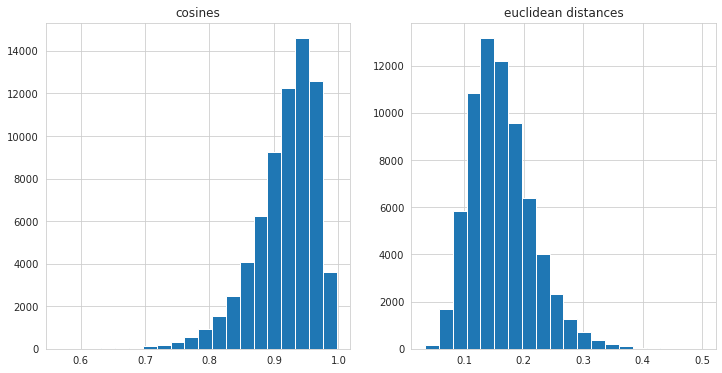

In [11]:
plot_distances(articles_train_topics, highlights_train_topics)

cosines: mean 0.917, std 0.049
euclidean distances: mean 0.16, std 0.051


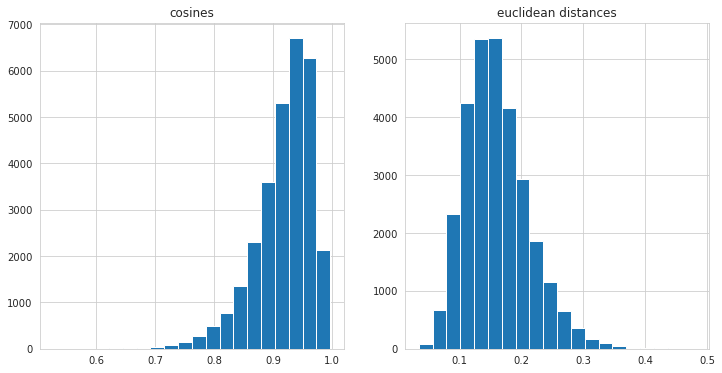

In [12]:
plot_distances(articles_val_topics, highlights_val_topics)

### 5. dataset and dataloaders

In [13]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [14]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [15]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [16]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([95, 128])
torch.Size([22, 128])


### 6. model architecture

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [18]:
writer = SummaryWriter()

In [19]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/gen2_adv.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### 7. Topic difference for predictions

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=False)

In [21]:
predicted_train = []
for i, batch in enumerate(train_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G(article, highlight, teacher_forcing_ratio=0.)
    predicted_train += tensor_to_text(preds, sp)
    
predicted_val = []
for i, batch in enumerate(val_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G(article, highlight, teacher_forcing_ratio=0.)
    predicted_val += tensor_to_text(preds, sp)
    
predicted_train_words = process_texts(predicted_train, bigram=bigram, lemmas=lemmas)
predicted_train_corpus = [id2word.doc2bow(text) for text in predicted_train_words]
predicted_train_topics = [get_topic_vector(lda_model, text) for text in predicted_train_corpus]
predicted_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_train_corpus]

predicted_val_words = process_texts(predicted_val, bigram=bigram, lemmas=lemmas)
predicted_val_corpus = [id2word.doc2bow(text) for text in predicted_val_words]
predicted_val_topics = [get_topic_vector(lda_model, text) for text in predicted_val_corpus]
predicted_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_val_corpus]

cosines: mean 0.902, std 0.062
euclidean distances: mean 0.174, std 0.059


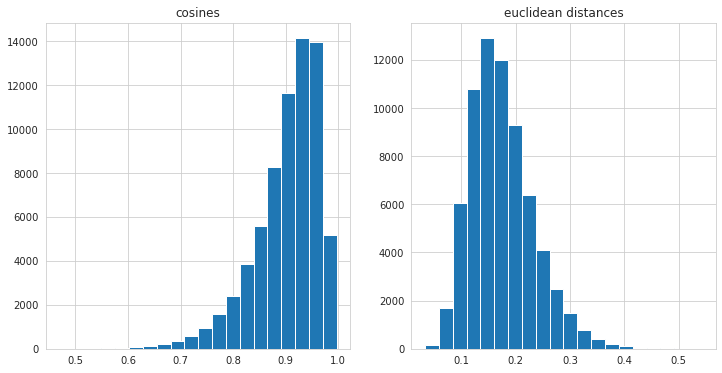

In [22]:
plot_distances(articles_train_topics, predicted_train_topics)

cosines: mean 0.895, std 0.066
euclidean distances: mean 0.179, std 0.06


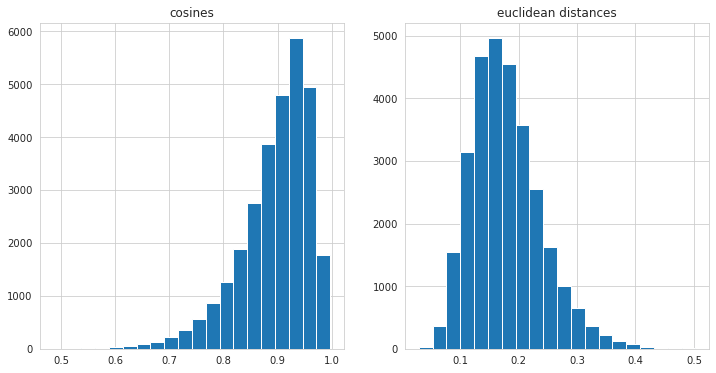

In [23]:
plot_distances(articles_val_topics, predicted_val_topics)

cosines: mean 0.953, std 0.04
euclidean distances: mean 0.106, std 0.048


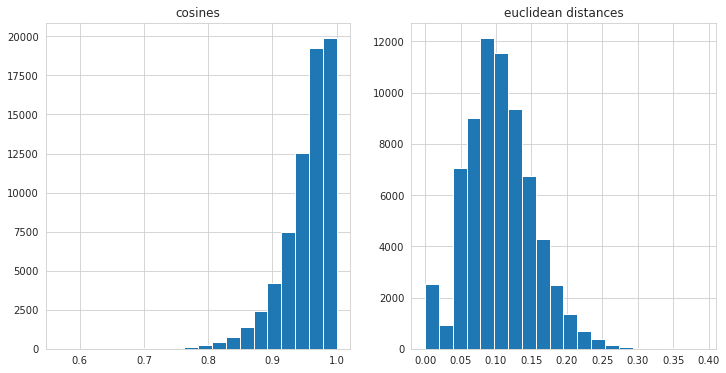

In [24]:
plot_distances(highlights_train_topics, predicted_train_topics)

cosines: mean 0.928, std 0.052
euclidean distances: mean 0.134, std 0.051


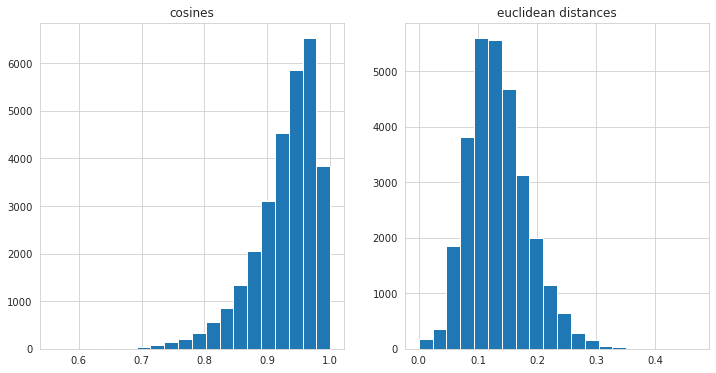

In [25]:
plot_distances(highlights_val_topics, predicted_val_topics)

### 8. adversarial training with topic difference reward

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
writer = SummaryWriter()

In [28]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [29]:
n_epochs = 200
beta = 0.2
teacher_forcing = 0.6

generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion_ml = nn.CrossEntropyLoss(ignore_index=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, 'min', patience=5)

G_losses = []
iter_num = -1
G_ce_val_losses = []

In [ ]:
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    beta += 0.02 * epoch_idx
    beta = min(0.95, beta)
    
    teacher_forcing -= 0.02 * epoch_idx
    teacher_forcing = max(0, teacher_forcing)
    
    total_G_loss = 0.
    G.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        iter_num += 1
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)

        # Generator
        generator_optimizer.zero_grad()
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=teacher_forcing)
        
        texts = tensor_to_text(generated_highlight, sp)
        predicted_corpus = [id2word.doc2bow(text.split()) for text in texts]
        predicted_topics = [get_topic_vector(lda_model, text) for text in predicted_corpus]
        
        texts = tensor_to_text(article, sp, beam_search=True)
        article_corpus = [id2word.doc2bow(text.split()) for text in texts]
        article_topics = [get_topic_vector(lda_model, text) for text in article_corpus]

        rewards = [[cosine(article_topic, predicted_topic)]*generated_highlight.size(0)
                   for article_topic, predicted_topic in zip(article_topics, predicted_topics)]
        rewards = torch.tensor(rewards).to(device)
        writer.add_scalar('Reward/train', torch.mean(rewards).item(), iter_num)
        # rewards = 1 - rewards
       
        pg_loss = G.batch_pgloss_generated(gen_out, generated_highlight.permute(1, 0), rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        loss.backward()
        
        generator_optimizer.step()
        writer.add_scalar('Loss_train/loss', loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/ml_loss', ml_loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/pg_loss', pg_loss.data.item(), iter_num)
        total_G_loss += loss.data.item() * article.size(1)
        
    G_losses.append(total_G_loss / len(train_dataset))
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    total_ml_loss = 0.
    total_pg_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=0.)
        
        texts = tensor_to_text(generated_highlight, sp)
        predicted_corpus = [id2word.doc2bow(text.split()) for text in texts]
        predicted_topics = [get_topic_vector(lda_model, text) for text in predicted_corpus]
        
        texts = tensor_to_text(article, sp)
        article_corpus = [id2word.doc2bow(text.split()) for text in texts]
        article_topics = [get_topic_vector(lda_model, text) for text in article_corpus]
    
        rewards = [[cosine(article_topic, predicted_topic)]*generated_highlight.size(0)
                   for article_topic, predicted_topic in zip(article_topics, predicted_topics)]
        rewards = torch.tensor(rewards).to(device)
        total_reward += torch.mean(rewards).item() * article.size(1)
        # rewards = 1 - rewards
        pg_loss = G.batch_pgloss_generated(gen_out, generated_highlight.permute(1, 0), rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=0.)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        total_loss += loss.data.item() * article.size(1)
        
        total_ml_loss += ml_loss.data.item() * article.size(1)
        total_pg_loss += pg_loss.data.item() * article.size(1)
        
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/loss', total_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/ml_loss', total_ml_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/pg_loss', total_pg_loss / len(val_dataset), iter_num)
    
    writer.add_scalar('Params/beta', beta, iter_num)
    writer.add_scalar('Params/teacher_forcing', teacher_forcing, iter_num)
    
    scheduler.step(total_loss)
    
    indices = sps.randint(0, out.size(1)).rvs(size=10)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        writer.add_text('Texts/pred', pred, iter_num)
        writer.add_text('Texts/truth', truth, iter_num)
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

539it [02:55,  3.07it/s]
1it [00:00,  7.06it/s]

epoch 0 G loss: 2.5585165969353576


231it [00:34,  6.64it/s]
0it [00:00, ?it/s]

predicted: pak will an asian statue under wc imran khanakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: hospital hospital hospital hospital hospital hospitalss dised to hospitals
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: 36 deported 36 yr old from kashmir over isi links isis
truth: uae deports indian over suspected links with isis

predicted: australia australia is a good good of a zealand coach
truth: sledging is a fun part of the game aus coach justin langer

predicted: woman finds fd after being finds malfunction in us
truth: us woman severely injured after mistaking dynamite for candle

predicted: woman finds fd after being finds malfunction in us
truth: us woman severely injured after mistaking dynamite for candle

predicted: kejriwal kejriwal in defamation case case filed against police
truth: delhi cm discharged in defamation case over thulla remark

predicted: armyable to soldiers against soldiers soldier

539it [02:56,  3.06it/s]
1it [00:00,  7.04it/s]

epoch 1 G loss: 2.55449757811918


231it [00:34,  6.63it/s]
0it [00:00, ?it/s]

predicted: whatsapp must have a grievance to to news union minister
truth: whatsapp must have grievance officer in india it min to ceo

predicted: sachin attends wedding ceremony of pandya s badkhuri
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: indianss black meteorites found for 40 years ago
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: un probing syrian chief syrians to syrian war syrian
truth: enough evidence to convict syrian prez of war crimes un

predicted: man creates selfable from car in car cars
truth: man turns his car into a drivable hot tub

predicted: barca first first club club to spend 1 billion in uaes
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: deatheeling after gorkhaland after after ins in
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: 36 deported 36 yr old engineer over suspected links links isis
truth: uae deports indian over susp

539it [02:56,  3.05it/s]
1it [00:00,  6.78it/s]

epoch 2 G loss: 2.5493019015437324


231it [00:35,  6.59it/s]
0it [00:00, ?it/s]

predicted: iit roorkee float floating device can generate water water water
truth: iit roorkee tests device to generate electricity from river flow

predicted: i was threaten to change birth till school till school 18 yrs old rape
truth: was threatened to change asaram rape victim s age principal

predicted: sports can t run run bysss sports sports min
truth: sports can t be run by bureaucrats sports minister rathore

predicted: air india flight denied to flight on flight denied to board
truth: air india refuses to let wheelchair bound passenger on plane

predicted: sachin attends wedding ceremony of pandya s badkhuri
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: nasa shares 1 1 lakh indians on a a chip
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: facebook asks us to share info of info reports
truth: facebook asks us banks for users financial data report

predicted: am b aishwarya bachchaned in s in panama papers probe


537it [02:55,  3.02it/s]

In [ ]:
save_path = 'saved_models/gen_topic3_adv.pth'
torch.save(G.state_dict(), save_path)